In [46]:
%matplotlib 
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [47]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [49]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [50]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [51]:
# View all of the classes that automap found
print("Reflected Classes:")
for cls in Base.classes:
    print(cls.__name__)
    

Reflected Classes:
measurement
station


In [52]:
# Save references to each table
tables = {table_name: getattr(Base.classes, table_name)
         for table_name in Base.classes.keys()}

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)  # Ensure session is initialized
measurement = tables['measurement']
station = tables['station']

# Query the first 5 rows of the measurement table   
first_five_measurements = session.query(measurement).limit(5).all()
# Print the first 5 rows
print("\nFirst 5 Rows of Measurement Table:")
for row in first_five_measurements:
    print(row.__dict__)
    print( "----------------------------------------------------------------------------------------------------------------------------------------------------------------------------")  # Separator for readability
#Print cooresponding coloumns names
print("\nColumn Names in Measurement Table:")
for column in measurement.__table__.columns:
    print(column.name)



First 5 Rows of Measurement Table:
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000017DC03EE090>, 'station': 'USC00519397', 'prcp': 0.08, 'id': 1, 'tobs': 65.0, 'date': '2010-01-01'}
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000017DC0379070>, 'station': 'USC00519397', 'prcp': 0.0, 'id': 2, 'tobs': 63.0, 'date': '2010-01-02'}
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x0000017DC0378B90>, 'station': 'USC00519397', 'prcp': 0.0, 'id': 3, 'tobs': 74.0, 'date': '2010-01-03'}
-----------------------------------------------------------------------------------------------

# Exploratory Precipitation Analysis

In [54]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print("\nMost Recent Date in Measurement Table:")
print(most_recent_date)


Most Recent Date in Measurement Table:
2017-08-23


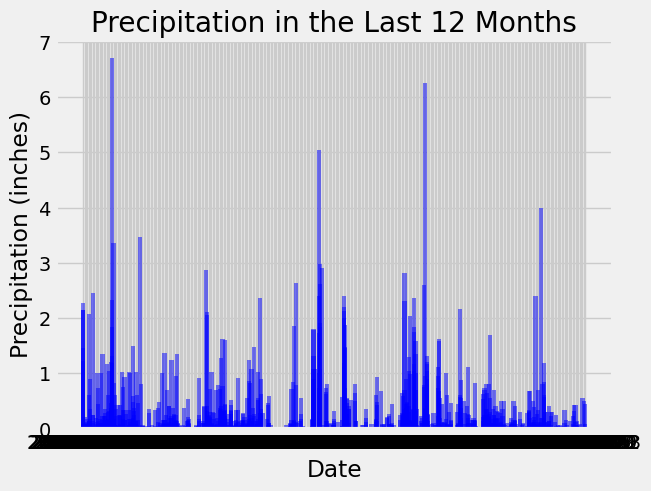

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_12_precip=session.query(measurement.date, measurement.prcp).filter(
    measurement.date >= dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
).order_by(measurement.date).all()

# Calculate the date one year from the last date in data set.
most_recent_date_dt = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date_dt - dt.timedelta(days=365)



# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(
    measurement.date >= one_year_ago
).order_by(measurement.date).all()



# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_12_precip_df = pd.DataFrame(precip_data, columns=['date', 'prcp'])




# Sort the dataframe by date
last_12_precip_df = last_12_precip_df.sort_values(by='date')



# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(last_12_precip_df['date'], last_12_precip_df['prcp'], width=3, color='blue', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation in the Last 12 Months')


plt.show()


In [56]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = last_12_precip_df['prcp'].describe()
print("\nSummary Statistics for Precipitation Data:")
print(summary_stats)



Summary Statistics for Precipitation Data:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [57]:
# Design a query to calculate the total number of stations in the dataset
print(f"Total number of stations: {session.query(func.count(station.id)).scalar()}")



Total number of stations: 9


In [58]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    measurement.station,
    func.count(measurement.id)
).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations_df = pd.DataFrame(active_stations, columns=['station', 'count'])
print("\nMost Active Stations:")
print(active_stations_df)




Most Active Stations:
       station  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations_df.iloc[0]['station']
most_active_station_temp = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()
most_active_station_temp_df = pd.DataFrame(most_active_station_temp, columns=['min_temp', 'max_temp', 'avg_temp'])
print("\nTemperature Statistics for Most Active Station:")
print(most_active_station_temp_df)





Temperature Statistics for Most Active Station:
   min_temp  max_temp   avg_temp
0      54.0      85.0  71.663781


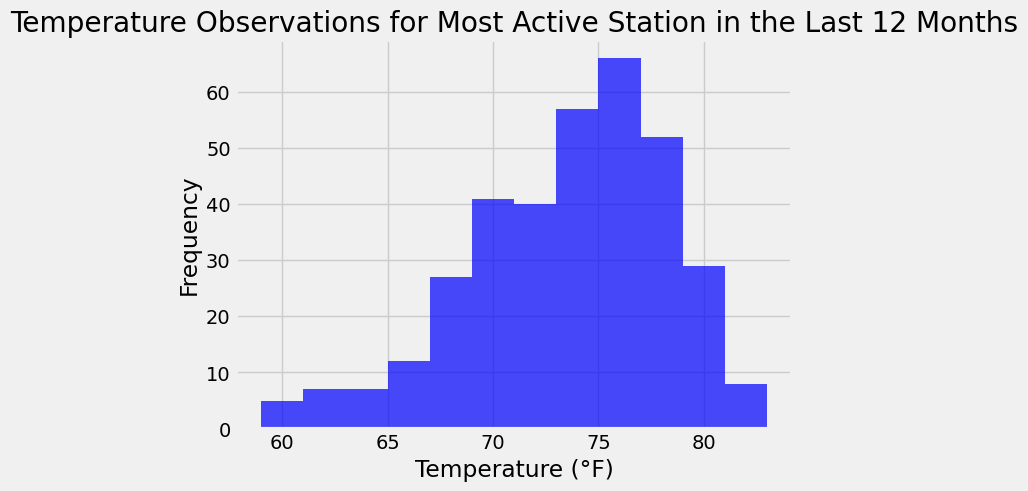

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = active_stations_df.iloc[0]['station']
last_12_tobs = session.query(measurement.tobs).filter(
    measurement.station == most_active_station_id,
    measurement.date >= one_year_ago
).order_by(measurement.date).all()

# Convert the query results to a DataFrame
last_12_tobs_df = pd.DataFrame(last_12_tobs, columns=['tobs'])

# Plot the histogram
plt.hist(last_12_tobs_df['tobs'], bins=12, color='blue', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station in the Last 12 Months')
plt.show()




# Close Session

In [61]:
# Close Session
session.close()